In [9]:
import torch
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from model import ExponentialKernelFiringRateModel

from sklearn.decomposition import SparsePCA, PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram

In [190]:
def gen_dataset(params, threshold=0.5):
    with open("model/labels.pickle", "rb") as f:
        labels = pickle.load(f)
    
    chosen_ids = filter(lambda x: params[x]["evr2"] > threshold, params.keys())
    
    dataset = {}
    for cell_id in chosen_ids:
        y = labels[cell_id]
        p = params[cell_id]["params"]
        model = ExponentialKernelFiringRateModel.from_params(p)
        
        a = p["a"].reshape(-1)
        b = p["b"].reshape(-1)
        pc = p["g"]["poly_coeff"].reshape(-1)
        gb = p["g"]["b"].reshape(-1)
        mc = p["g"]["max_current"].reshape(-1)
        mfr = p["g"]["max_firing_rate"].reshape(-1)
        x = torch.cat([a, b, pc, gb, mc, mfr])
        
        dataset[cell_id] = (x, y, params[cell_id]["evr2"])
        
    return dataset

def get_line_name(df, cell_id):
    return df[df["specimen__id"] == cell_id]["line_name"].to_numpy()[0]

def get_labels(cell_ids):
    df = pd.read_csv("data/metadata.csv")
    line_names = ["Pvalb", "Sst", "Vip", "Htr3a", "Ndnf", "Cux2", "Nr5a1", "Ntsr1", "Rorb", "Scnn1a", "Tlx3", "Rbp4"]
    new_cell_ids = []
    labels = []
    
    for cell_id in cell_ids:
        line_name = get_line_name(df, cell_id)
        if type(line_name) != str or "|" in line_name:
            pass
        elif line_name.split("-")[0] in line_names:
            new_cell_ids.append(cell_id)
            labels.append(line_name.split("-")[0])
    
    types, counts = np.unique(labels, return_counts=True)
    types = types[counts > 20]
    new_cell_ids, labels = zip(*list(filter(lambda x: x[1] in types, zip(new_cell_ids, labels))))
    
    return np.array(new_cell_ids), np.array(labels)

def get_dataset(dataset=None):
    if dataset is None:
        with open("data/dataset.pickle", "rb") as f:
            dataset = pickle.load(f)
    cell_ids, ys = get_labels(dataset.keys())
    remove = [479298854, 489719193, 485060618, 486791945, 562535995, 321707905]# + [478110866]
    idxs = list(filter(lambda x: cell_ids[x] in remove, range(len(cell_ids))))
    cell_ids = [cell_ids[i] for i in range(len(cell_ids)) if i not in idxs]
    ys = [ys[i] for i in range(len(ys)) if i not in idxs]
    xs = np.array([dataset[cell_id][0].tolist() for cell_id in cell_ids])
    return xs, ys, cell_ids

def get_best_params_for_actv_bin_size(params, bin_size, actv_bin_size):
    best_params = {}
    
    cell_ids = set()
    for config in params:
        cell_ids = cell_ids.union(set(params[config].keys()))
    
    for cell_id in cell_ids:
        best_config = None
        best_evr = -1e10
        
        for config in params:
            if config[0] == bin_size and config[1] == actv_bin_size and cell_id in params[config] and params[config][cell_id]["evr1"] > best_evr:
                best_evr = params[config][cell_id]["evr1"]
                best_config = config
        
        # doesn't make sense
        if best_config is not None:
            best_params[cell_id] = params[best_config][cell_id]
        
    return best_params

In [143]:
import torch.nn.functional as F
from torcheval.metrics.functional import multiclass_f1_score, multiclass_accuracy, multiclass_confusion_matrix

def summary(model, dataloader, n_classes):
    y_pred, y = get_predictions(model, dataloader, n_classes)
    f = multiclass_f1_score(y_pred, y, num_classes=n_classes, average="weighted")
    acc = multiclass_accuracy(y_pred, y, num_classes=n_classes)
    return f, acc

def get_predictions(model, dataloader, n_classes):
    ys, ys_pred = [], []
    with torch.no_grad():
        for X, y, w in dataloader:
            X = X.to(torch.float32)
            y1 = torch.einsum("ij,j->i", y, torch.arange(n_classes))
            y = y.to(torch.float32)
            ys_pred.append(model(X))
            ys.append(y1)
    return torch.cat(ys_pred), torch.cat(ys)

class ParameterDataset(torch.utils.data.Dataset):
    def __init__(self, xs, ys, label_map):
        self.n_classes = len(label_map)
        self.xs = list(map(torch.tensor, xs))
        self.ys = list(map(torch.tensor, [label_map[y] for y in ys]))
        self.ys = list(map(lambda x: F.one_hot(x, num_classes=self.n_classes), self.ys))
        
        types, counts = np.unique(ys, return_counts=True)
        ws = (1 / counts) / np.sum(1 / counts)
        w_map = {t: w for t, w in zip(types, ws)}
        self.ws = list(map(lambda x: w_map[x], ys))

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, idx):
        return self.xs[idx], self.ys[idx], self.ws[idx]

from sklearn.model_selection import train_test_split

def train_model(xs, ys, pca=True, scale=True, linear=False):
    types = np.unique(ys).tolist()
    label_map = {t: i for i, t in enumerate(types)}
    n_classes = len(label_map)

    z = list(zip(xs, ys, cell_ids))
    ztr, zte = train_test_split(z, test_size=0.35, stratify=ys)
    Xtr, ytr, cell_ids_tr = zip(*ztr)
    Xte, yte, cell_ids_te = zip(*zte)
    z = list(zip(Xtr, ytr, cell_ids_tr))
    ztr, zval = train_test_split(z, test_size=0.15, stratify=ytr)
    Xtr, ytr, cell_ids_tr = zip(*ztr)
    Xval, yval, cell_ids_val = zip(*zval)
    
    if scale:
        scaler = StandardScaler()
        scaler.fit(Xtr)
        Xtr = scaler.transform(Xtr)
        Xval = scaler.transform(Xval)
        Xte = scaler.transform(Xte)
        xs = scaler.transform(xs)
    
    if pca:
        scaler = PCA(n_components=5)
        scaler.fit(Xtr)
        Xtr = scaler.transform(Xtr)
        Xval = scaler.transform(Xval)
        Xte = scaler.transform(Xte)
        xs = scaler.transform(xs)

    train_dataset = ParameterDataset(Xtr, ytr, label_map)
    val_dataset = ParameterDataset(Xval, yval, label_map)
    test_dataset = ParameterDataset(Xte, yte, label_map)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(yte), shuffle=False)
    
    if linear:
        model = torch.nn.Sequential(
            torch.nn.Linear(len(xs[0]), n_classes)
        )
    else:
        model = torch.nn.Sequential(
            torch.nn.Linear(len(xs[0]), 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, n_classes)
        )

    types, counts = np.unique(ys, return_counts=True)
    ws = torch.tensor((1 / counts) / np.sum(1 / counts))

    criterion = torch.nn.CrossEntropyLoss(weight=ws)
    optim = torch.optim.Adam(model.parameters(), lr=0.005)
    epochs = 500

    train_accs = []
    train_f1s = []
    val_accs = []
    val_f1s = []

    for epoch in range(epochs):
        loss = 0
        for X, y, w in train_loader:
            X = X.to(torch.float32)
            y = y.to(torch.float32)
            y_pred = model(X)
            loss += criterion(y_pred, y)

        optim.zero_grad()
        loss.backward()
        optim.step()

        f_tr, acc_tr = summary(model, train_loader, n_classes)
        f_val, acc_val = summary(model, val_loader, n_classes)
        train_accs.append(acc_tr.item())
        train_f1s.append(f_tr.item())
        val_accs.append(acc_val.item())
        val_f1s.append(f_val.item())

        if (epoch + 1) % 10000 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Loss: {loss.item()}")

    #print_summary(model, train_loader, n_classes)
    f, acc = summary(model, test_loader, n_classes)

    if False:
        ts = list(range(len(train_accs)))
        
        plt.figure()
        plt.plot(ts, train_accs, label="train")
        plt.plot(ts, val_accs, label="val")
        plt.xlabel("epoch")
        plt.ylabel("accuracy")

        plt.figure()
        plt.plot(ts, train_f1s, label="train")
        plt.plot(ts, val_f1s, label="val")
        plt.ylabel("f1 score");
        
    return model, f.item(), acc.item()

In [144]:
def kernel(x, a):
    ds = torch.tensor([1.0000, 0.6321, 0.3297, 0.1813, 0.0952, 0.0392, 0.0198, 0.0100])
    return torch.einsum("ij,j->i", torch.tensor(a).to(torch.float32), torch.pow(1 - ds, torch.tensor(x)))

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [145]:
with open("model/all_params.pickle", "rb") as f:
    all_params = pickle.load(f)

KeyboardInterrupt: 

In [146]:
xs.shape

(765, 21)

In [191]:
bin_size = 20
actv_bin_size = 20
params = get_best_params_for_actv_bin_size(all_params, bin_size, actv_bin_size)
dataset = gen_dataset(params)
xs, ys, cell_ids = get_dataset(dataset)
ys = np.array(ys)

types, counts = np.unique(ys, return_counts=True)
types = ["Htr3a", "Ndnf", "Vip", "Sst", "Pvalb", "Cux2", "Nr5a1", "Scnn1a", "Rorb", "Ntsr1", "Rbp4"]
inhibitory = ["Pvalb", "Sst", "Vip", "Htr3a", "Ndnf"]

linear=True, binary=True, pca=False, scale=True
(all) f1 score: mean 0.7753, std 0.0146
(all) accuracy: mean 0.7749, std 0.0145
------------------------
linear=True, binary=False, pca=False, scale=True
(all) f1 score: mean 0.3404, std 0.0252
(all) accuracy: mean 0.3562, std 0.0223
------------------------


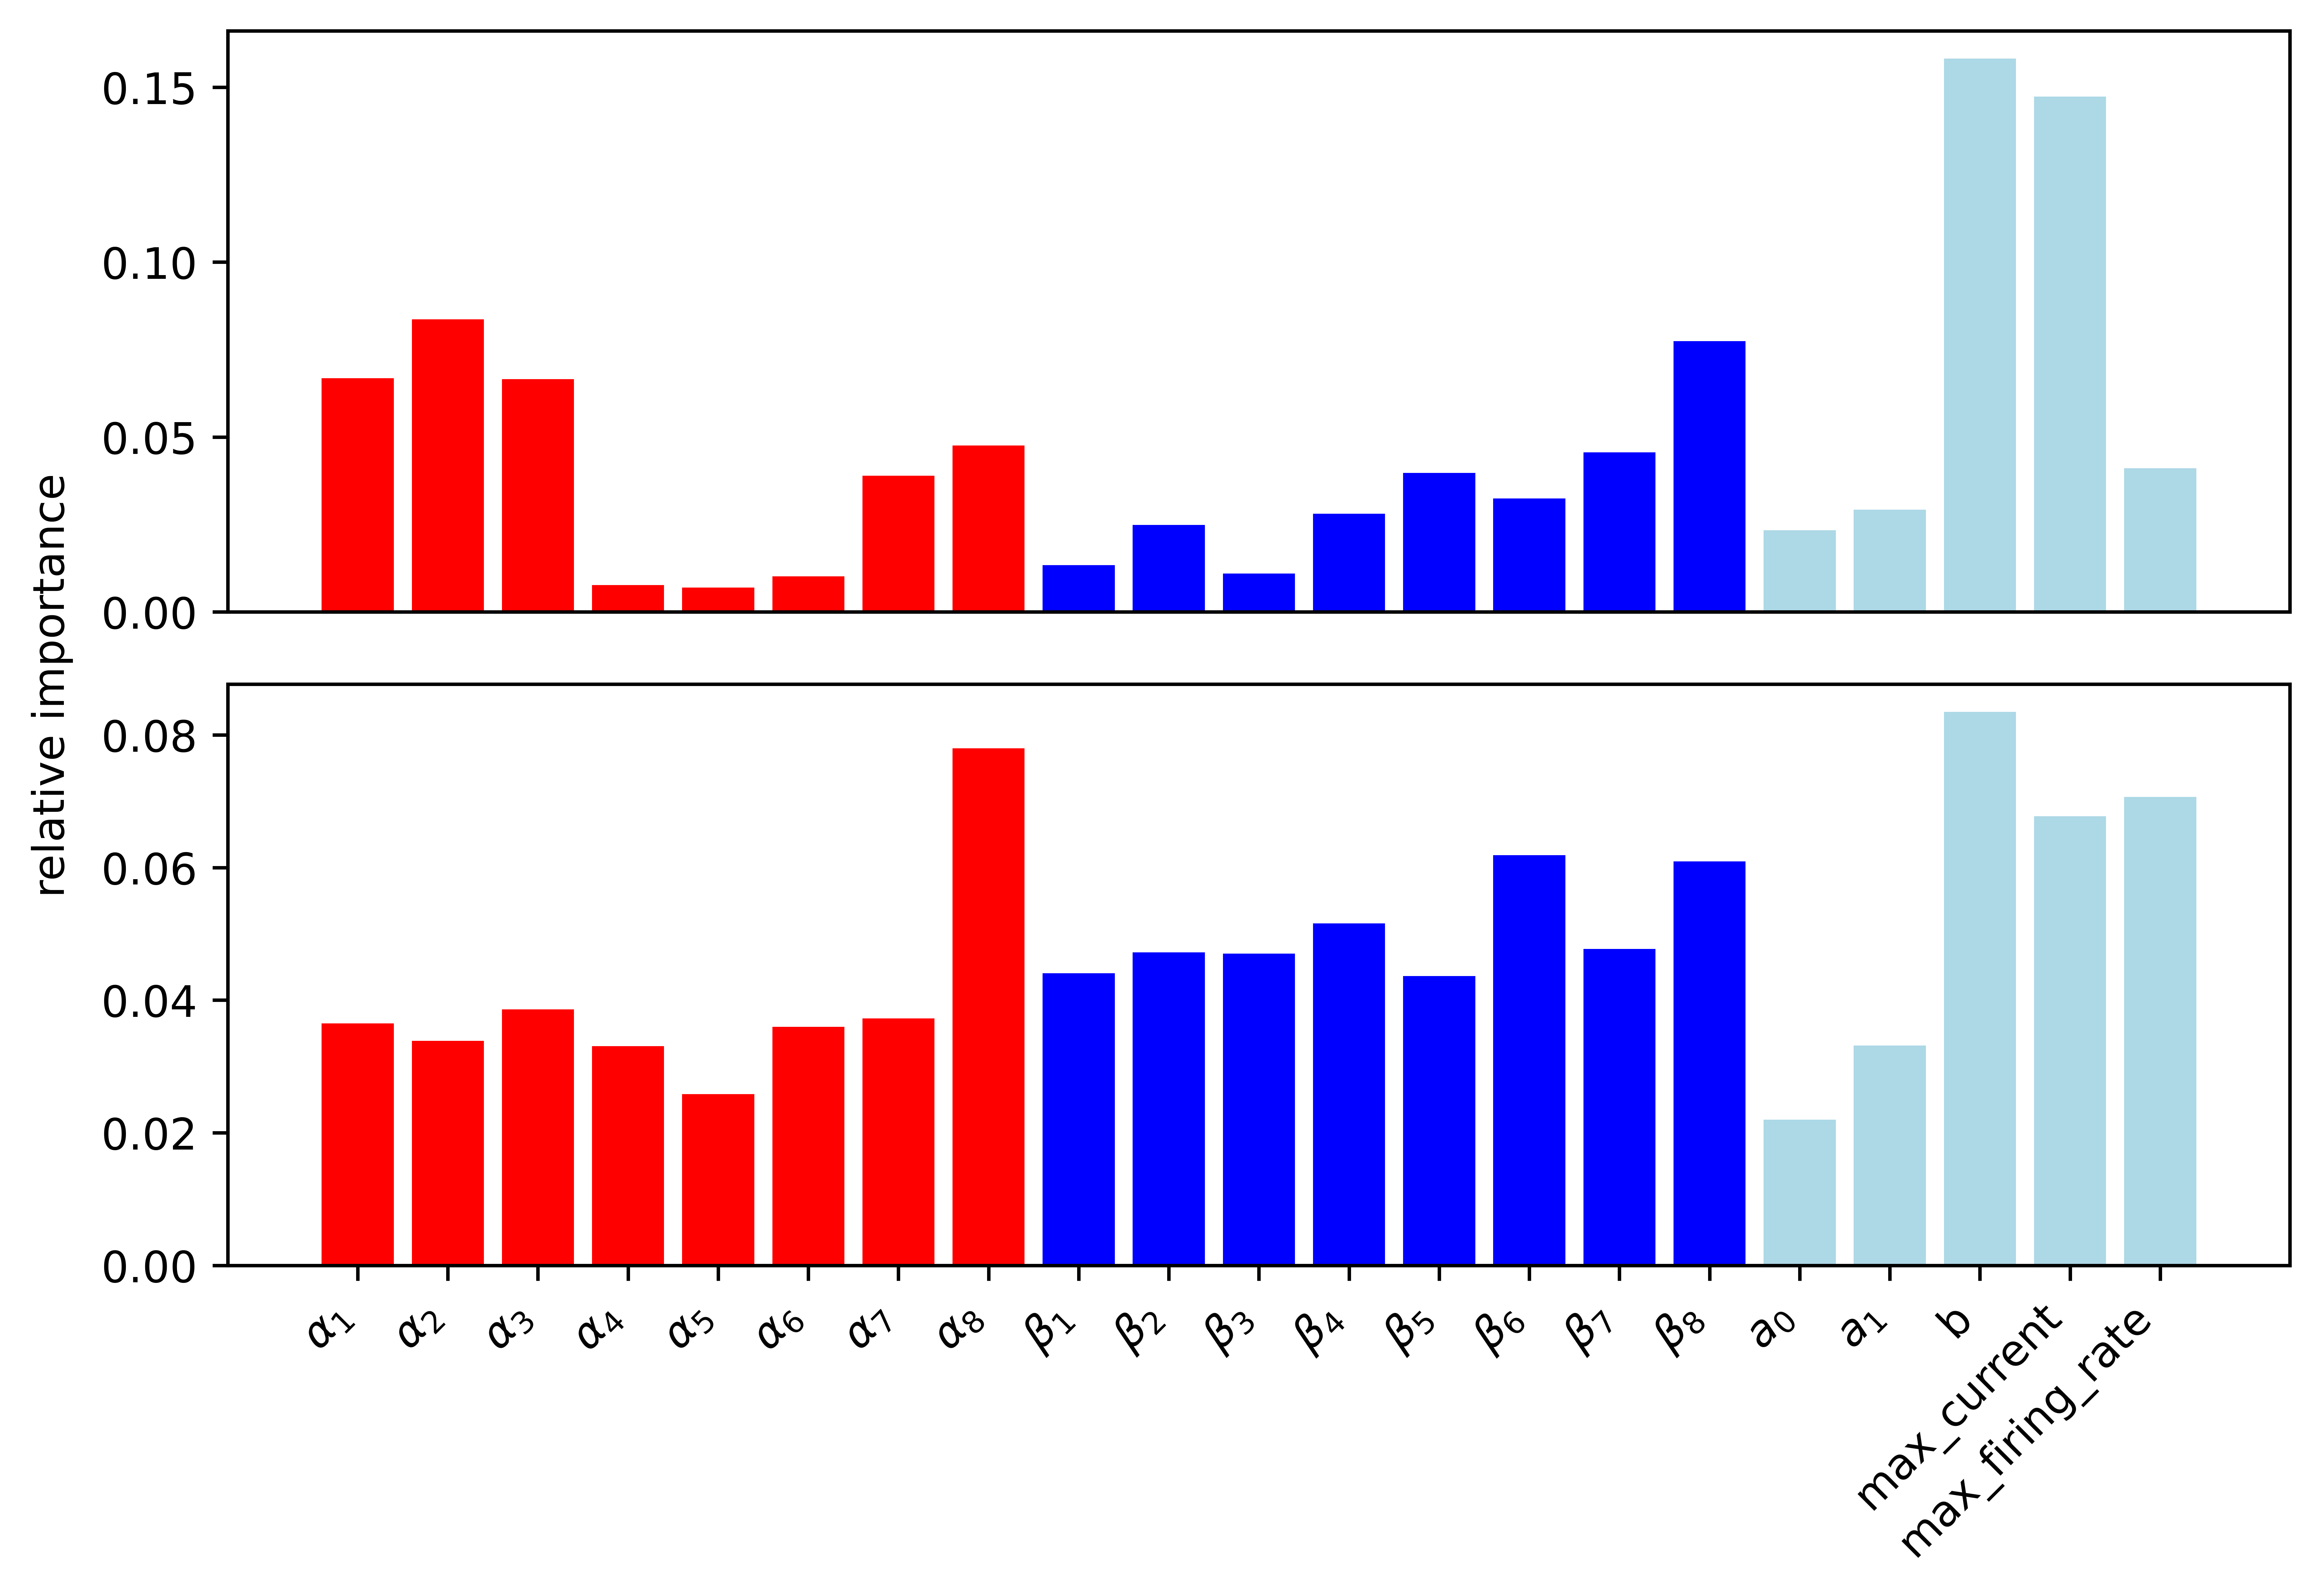

In [205]:
wss = []
for binary in [True, False]:
        print(f"{linear=}, {binary=}, {pca=}, {scale=}")
        for p in ["all"]:
            if binary:
                labels = ["inhibitory" if y in inhibitory else "excitatory" for y in ys]
            else:
                labels = ys

            fs = []
            accs = []
            for _ in range(10):
                model, f, acc = train_model(xs, labels, pca=False, scale=True, linear=True)
                fs.append(f)
                accs.append(acc)
            
            print(f"({p}) f1 score: mean {np.mean(fs):.4f}, std {np.std(fs):.4f}")
            print(f"({p}) accuracy: mean {np.mean(accs):.4f}, std {np.std(accs):.4f}")
            if p == "all":
                ws = model[0].weight.detach().norm(dim=0)
                ws = ws / torch.sum(ws)
                wss.append(ws)
        print("------------------------")
        
                
fig, axs = plt.subplots(2, 1, figsize=(7.5, 4.5), dpi=1000)
fig.text(-0.01, 0.5, 'relative importance', va='center', rotation='vertical')
ax1 = axs[0]
ax2 = axs[1]

alpha = [f"$\\alpha_{i+1}$" for i in range(8)]
beta = [f"$\\beta_{i+1}$" for i in range(8)]
actv = [f"$a_{i}$" for i in range(4 if actv_bin_size > 20 else 2)] + ["b", "max_current", "max_firing_rate"]
labels = alpha + beta + actv
ax1.bar(labels, wss[0], color=(["r"]*8+["b"]*8+["lightblue"]*len(actv)))
ax2.bar(labels, wss[1], color=(["r"]*8+["b"]*8+["lightblue"]*len(actv)))
ax1.set_xticks([])

if binary:
    plt.xticks([])
fig.tight_layout()
plt.xticks(rotation=45, ha='right');

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([ 40, 136,  82, 162,  41,  42, 122,  74,  63]))


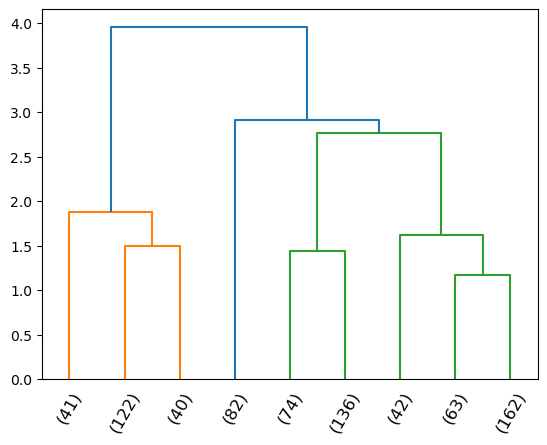

In [206]:
mapping = {t: i for i, t in enumerate(types)}
inv_mapping = {i: t for i, t in enumerate(types)}

xs_scaled = StandardScaler().fit_transform(xs)
xs_weighted = xs_scaled * wss[1].numpy()

n_clusters = 9
clustering = AgglomerativeClustering(n_clusters=n_clusters, compute_distances=True, metric="euclidean", linkage="ward")
clustering.fit(xs_weighted)

plot_dendrogram(clustering, truncate_mode="lastp", p=n_clusters, leaf_rotation=60.,
            leaf_font_size=12.)
print(np.unique(clustering.labels_, return_counts=True))

id1 = []
id2 = []
mat = np.zeros((n_clusters, len(types)))
for i, y, x, cell_id in zip(clustering.labels_, ys, xs, cell_ids):
    #if i == 6 and y == "Pvalb":
    #    print(cell_id, x)
    mat[i, mapping[y]] += 1

{'whiskers': [<matplotlib.lines.Line2D at 0x17b1d08e0>,
 'caps': [<matplotlib.lines.Line2D at 0x17b1d0730>,
 'boxes': [<matplotlib.lines.Line2D at 0x17b1d1390>],
 'medians': [<matplotlib.lines.Line2D at 0x17b1d1570>],
 'fliers': [<matplotlib.lines.Line2D at 0x17b1d2260>],
 'means': []}

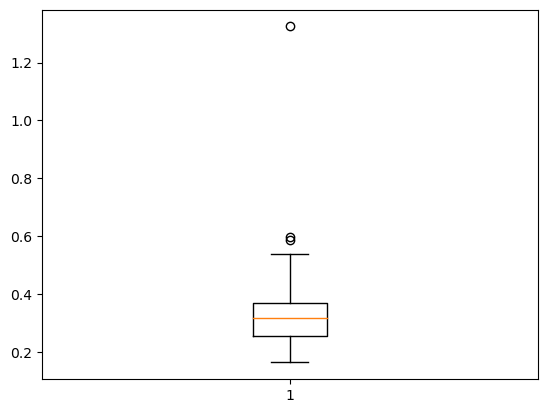

In [189]:
plt.boxplot(xs[ys=="Pvalb", -1])

In [207]:
idx_map = [(j, i) for i, j in enumerate(sorted(range(mat.shape[0]), key=lambda i: mat[i, :] @ np.array([-1 if x < 5 else 1 for x in range(len(types))])))]
#idx_map = [(j, i) for i, j in enumerate(sorted(range(mat.shape[0]), key=lambda i: norm[i, :].argmax()))]
perm = np.zeros((n_clusters, n_clusters))
for i, j in idx_map:
    perm[j, i] = 1
    
mat = perm @ mat

In [171]:
mat = mat[[0, 1, 3, 2, 4, 5, 8, 7, 6],:]

IndexError: index 8 is out of bounds for axis 0 with size 8

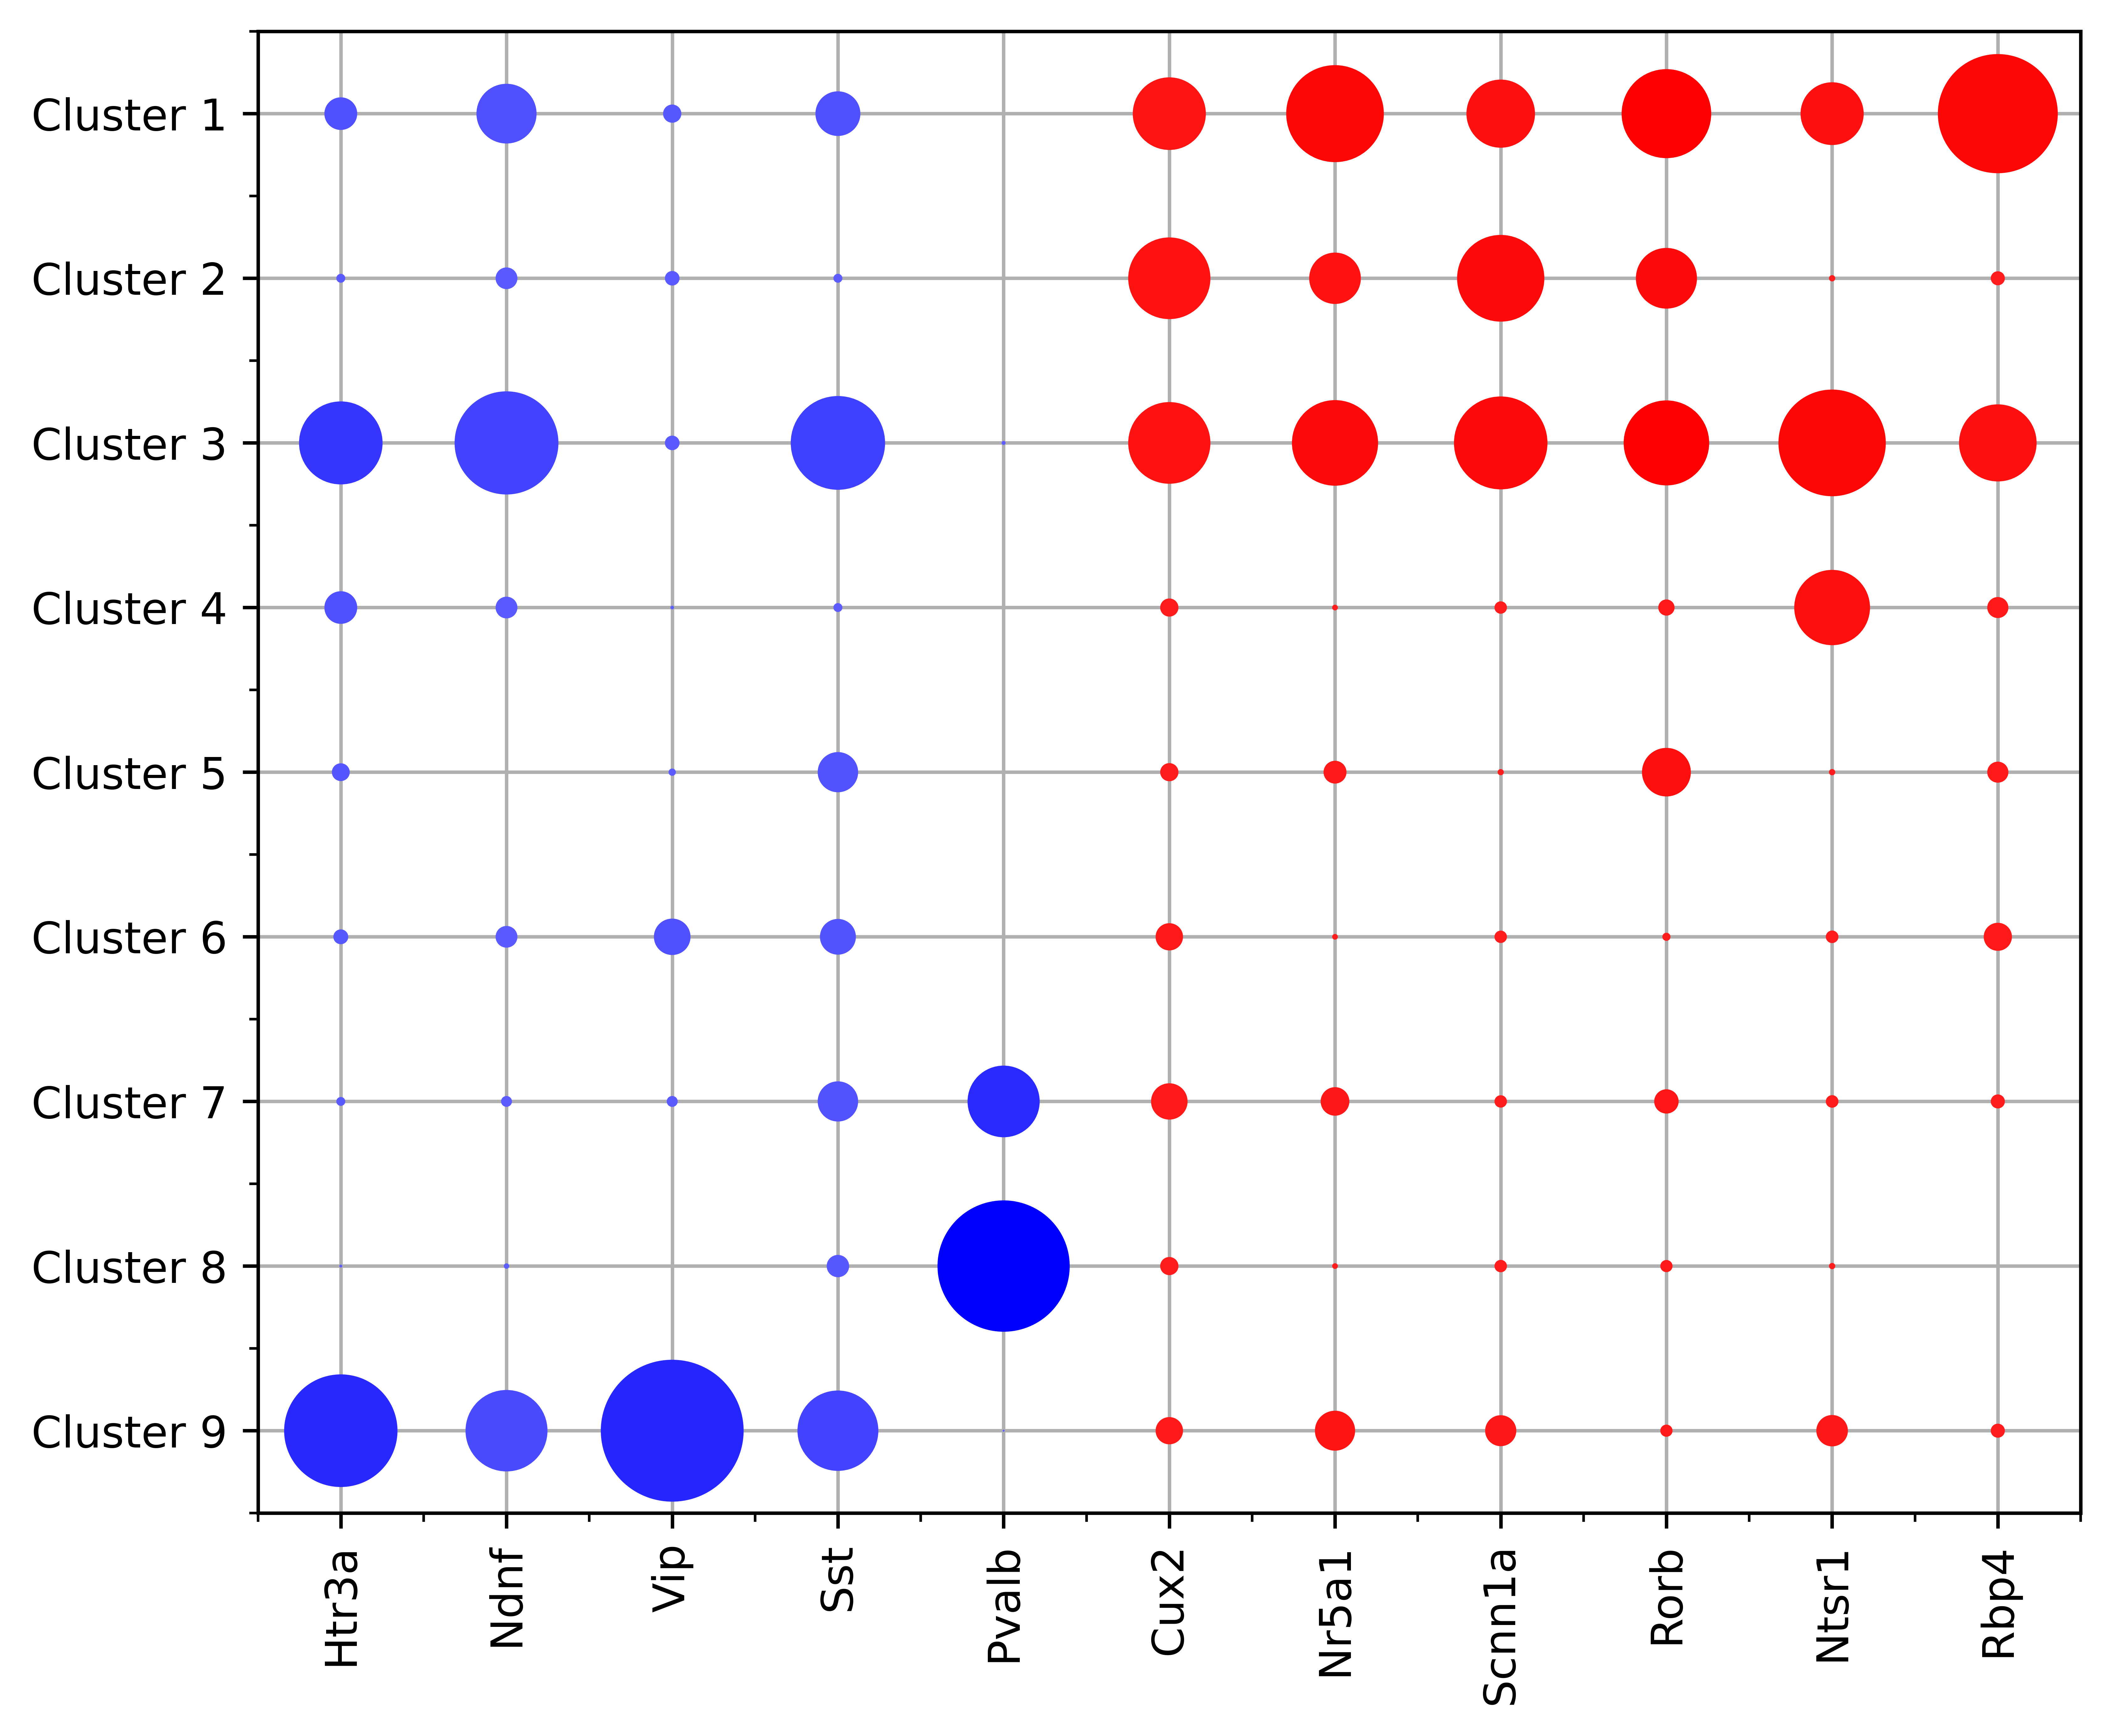

In [208]:
from matplotlib.collections import PatchCollection
from sklearn.preprocessing import normalize

N, M = mat.shape
ylabels = [f"Cluster {i+1}" for i in range(n_clusters)][::-1]
xlabels = [f"{inv_mapping[i]}" for i in range(len(types))]

x, y = np.meshgrid(np.arange(M), np.arange(N))
s = mat / mat.mean(axis=0)
c = np.zeros((N, M))
norm = mat / mat.max()
c[:, :5] = -2 - norm[:,:5]
c[:, 5:] = 2 + norm[:,5:]

fig, ax = plt.subplots(figsize=(7.5, 7.5 * N / M), dpi=1000)

#R = s/s.max()/2.2
R = normalize(s, norm='l2', axis=0) / 2.2
circles = [plt.Circle((j, i), radius=r, color='k', linewidth=10) for r, j, i in zip(R.flat, x.flat, y.flat)]
col = PatchCollection(circles, array=c.flatten(), cmap="bwr")
ax.add_collection(col)

ax.set(xticks=np.arange(M), yticks=np.arange(N),
       xticklabels=xlabels, yticklabels=ylabels)
ax.set_xticks(np.arange(M+1)-0.5, minor=True)
ax.set_yticks(np.arange(N+1)-0.5, minor=True)
ax.grid()
ax.set_axisbelow(True)
plt.xticks(rotation=90)
#fig.colorbar(col)

plt.show()

In [124]:
import sklearn

for x in [xs_weighted]:
    clustering = AgglomerativeClustering(n_clusters=len(types), compute_distances=True, metric="euclidean", linkage="ward")
    clustering.fit(x);
    #print(sklearn.metrics.v_measure_score(ys, clustering.labels_))
    print(sklearn.metrics.adjusted_rand_score(ys, clustering.labels_))
    print(sklearn.metrics.v_measure_score(ys, clustering.labels_))

0.0795782204364956
0.17774151644721542


Dont include:
Gad2
Slc17
Vertical line

Merge labels with same first part

Exclude cells without many samples

Focus:
Inhibitory:
Pvalb
Sst
Vip subset of Htr3a
Ndnf

Excitatory:
Cux2
Nr5a1
Ntsr1
Rorb
Scnn1a
Tlx3

UMAP for visualization only
Cluster (Ward) in PCA or parameter space

In [59]:
params = get_best_params_for_actv_bin_size(all_params, 20, 20)
dataset = gen_dataset(params)
xs, ys, cell_ids = get_dataset(dataset)
ys = np.array(ys)
types, counts = np.unique(ys, return_counts=True)
len(types)

11

/var/folders/_r/m9hbjyhd13bbv3lg031lk0fc0000gn/T/ipykernel_21400/948345140.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.einsum("ij,j->i", torch.tensor(a).to(torch.float32), torch.pow(1 - ds, torch.tensor(x)))
/var/folders/_r/m9hbjyhd13bbv3lg031lk0fc0000gn/T/ipykernel_21400/948345140.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.einsum("ij,j->i", torch.tensor(a).to(torch.float32), torch.pow(1 - ds, torch.tensor(x)))
/var/folders/_r/m9hbjyhd13bbv3lg031lk0fc0000gn/T/ipykernel_21400/948345140.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), r

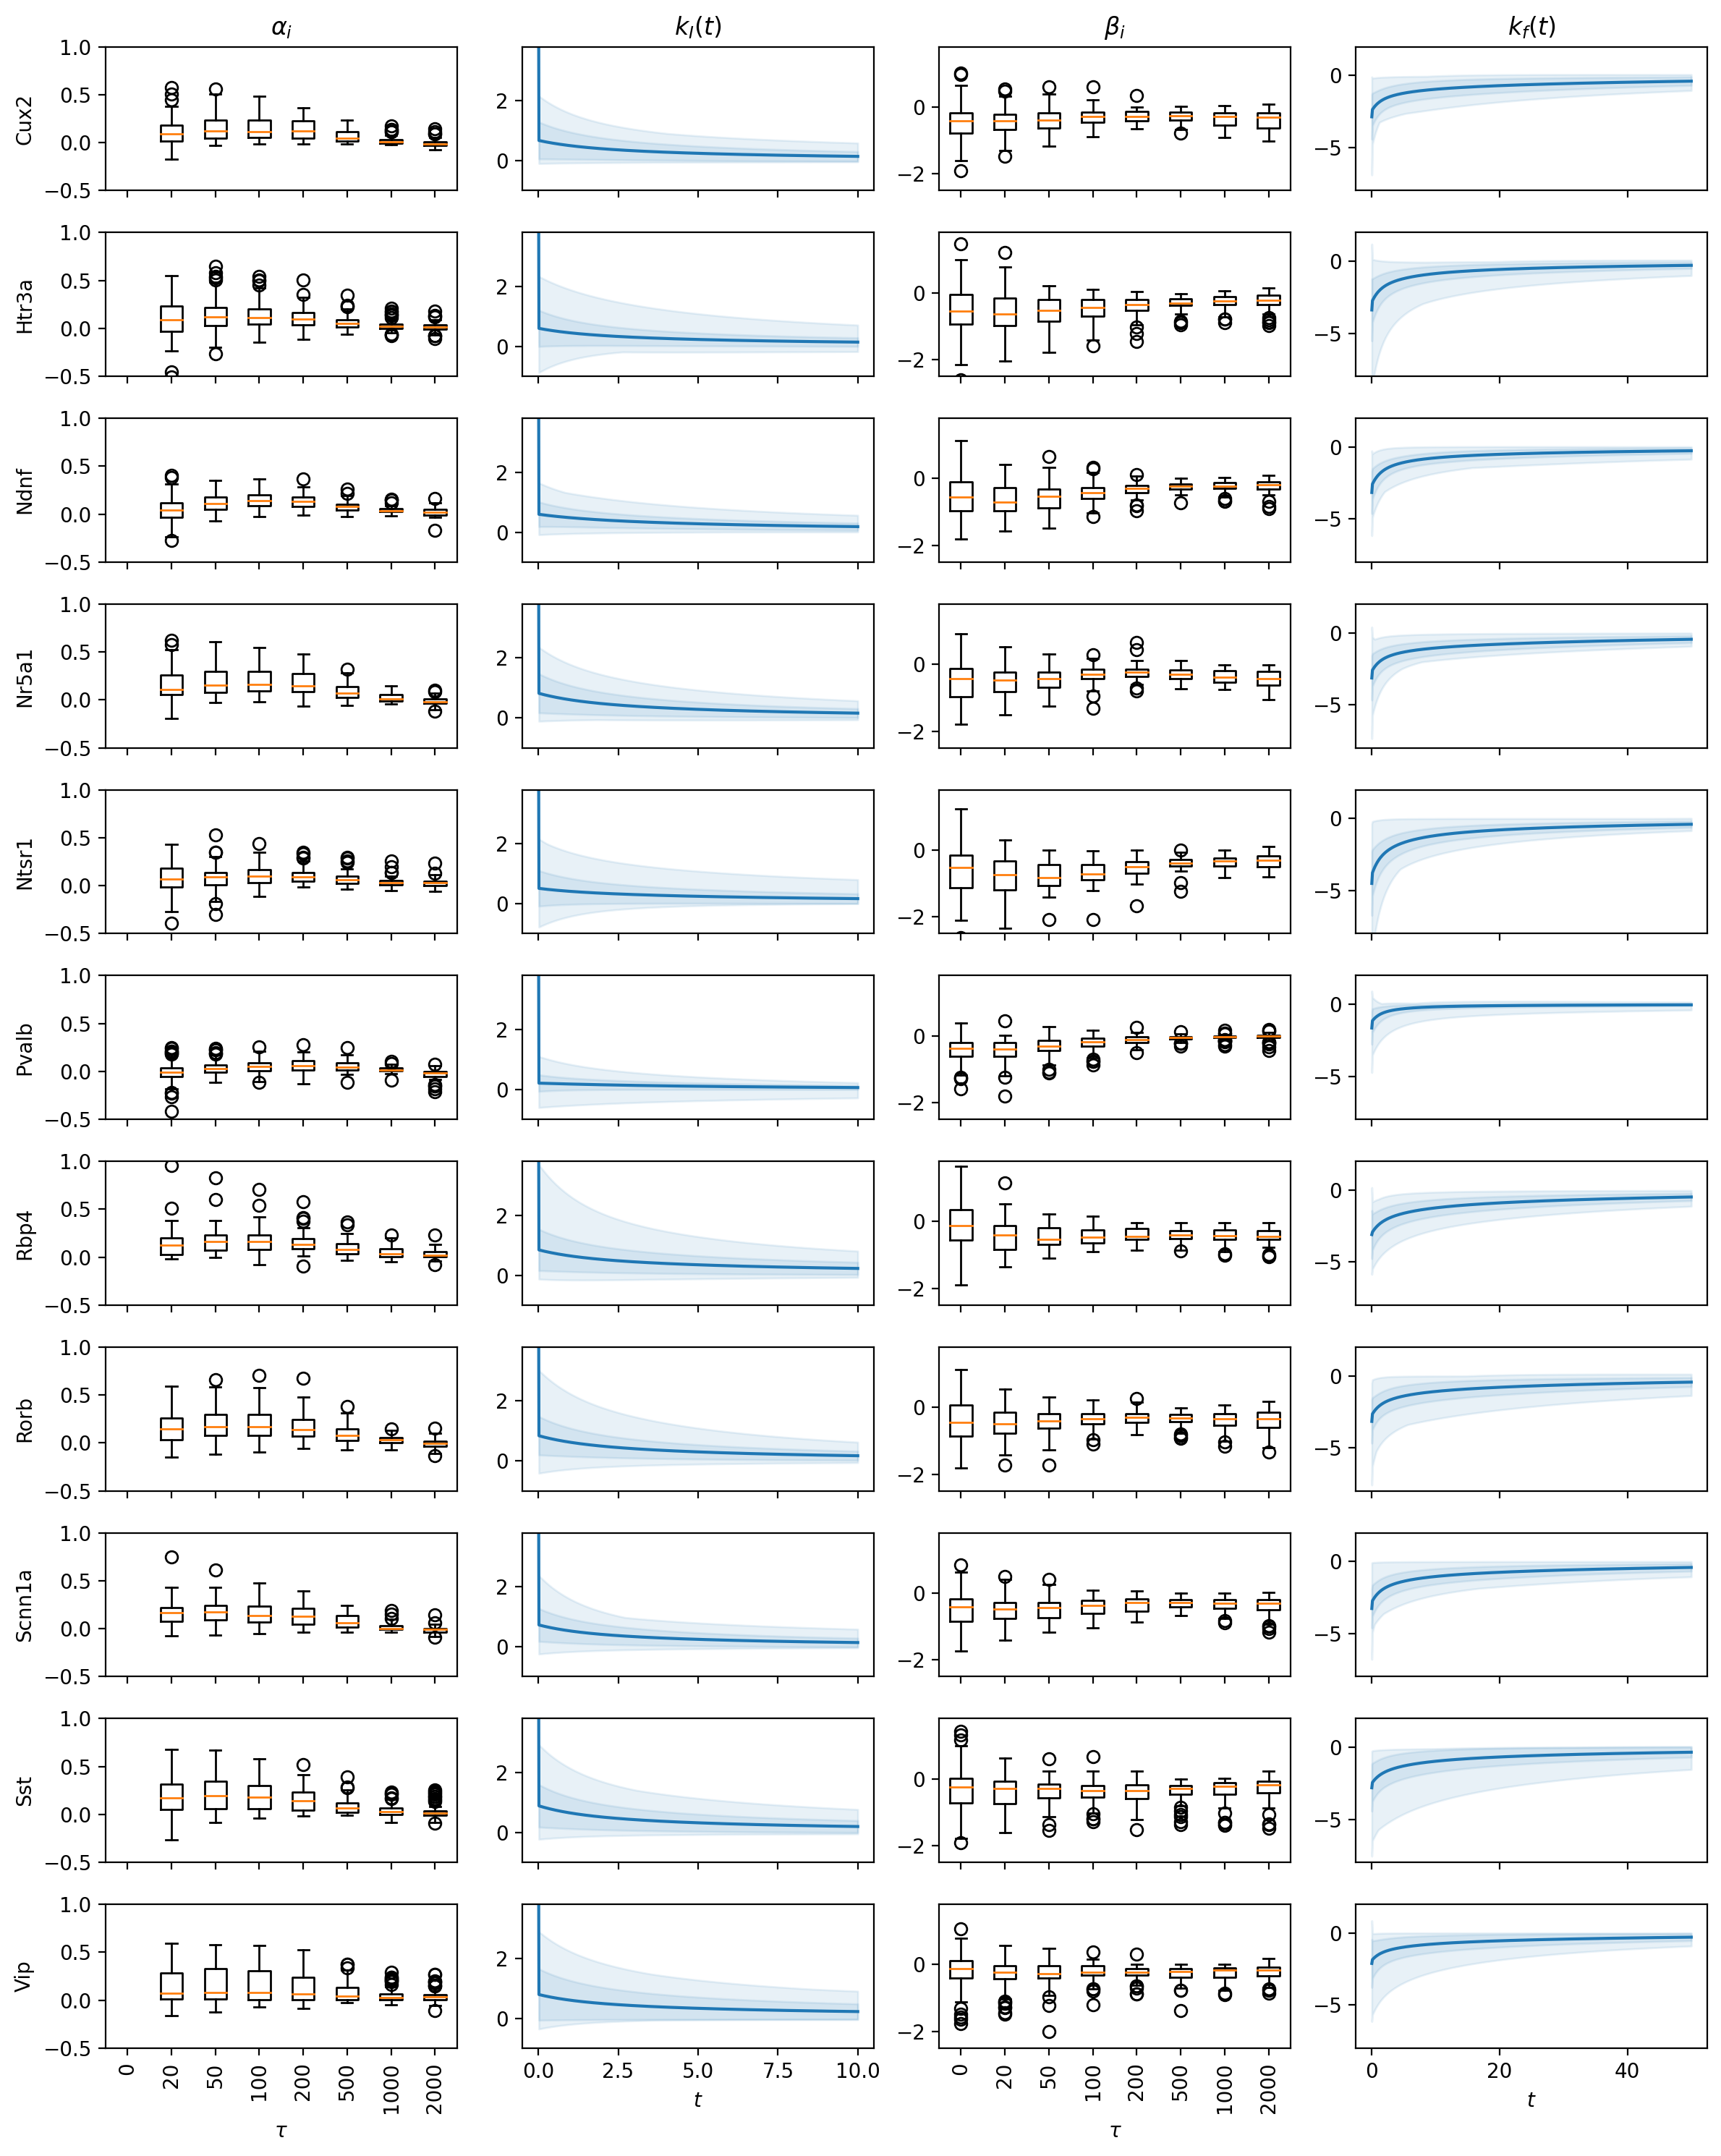

In [60]:
fig, ax = plt.subplots(len(types), 4, figsize=(12, 15), dpi=200)
for i, t in enumerate(types):
    
    a = xs[ys == t, :8]
    ax[i, 0].boxplot(a)
    ax[i, 0].xaxis.set_ticklabels([str(j) for j in [0, 20, 50, 100, 200, 500, 1000, 2000]], rotation=90)
    
    zs = torch.linspace(0, 10, 500)
    X = torch.stack([kernel(z, a) for z in zs])
    x_mean = torch.mean(X, dim=1)
    x_std = torch.std(X, dim=1)
    x_max = torch.max(X, dim=1)[0]
    x_min = torch.min(X, dim=1)[0]
    
    
    ax[i, 1].plot(zs, x_mean)
    ax[i, 1].fill_between(zs, x_mean - x_std, x_mean + x_std, alpha=0.1, color="tab:blue")
    ax[i, 1].fill_between(zs, x_min, x_max, alpha=0.1, color="tab:blue")
    
    
    b = xs[ys == t, 8:16]
    ax[i, 2].boxplot(b)
    ax[i, 2].xaxis.set_ticklabels([str(j) for j in [0, 20, 50, 100, 200, 500, 1000, 2000]], rotation=90)
    
    zs = torch.linspace(0, 50, 500)
    X = torch.stack([kernel(z, b) for z in zs])
    x_mean = torch.mean(X, dim=1)
    x_std = torch.std(X, dim=1)
    x_max = torch.max(X, dim=1)[0]
    x_min = torch.min(X, dim=1)[0]
    
    
    ax[i, 3].plot(zs, x_mean)
    ax[i, 3].fill_between(zs, x_mean - x_std, x_mean + x_std, alpha=0.1, color="tab:blue")
    ax[i, 3].fill_between(zs, x_min, x_max, alpha=0.1, color="tab:blue")
    
    ax[i, 0].set_ylabel(t)
    ax[i, 0].set_ylim([-0.5, 1])
    ax[i, 1].set_ylim([-1, 3.8])
    ax[i, 2].set_ylim([-2.5, 1.8])
    ax[i, 3].set_ylim([-8, 2])
    
    if i == 0:
        ax[i, 0].set_title("$\\alpha_i$")
        ax[i, 1].set_title("$k_I(t)$")
        ax[i, 2].set_title("$\\beta_i$")
        ax[i, 3].set_title("$k_f(t)$")
    
    if i < len(types)-1:
        for j in range(4):
            ax[i, j].xaxis.set_ticklabels([])
            
    if i == len(types) - 1:
        ax[i, 0].set_xlabel("$\\tau$")
        ax[i, 1].set_xlabel("$t$")
        ax[i, 2].set_xlabel("$\\tau$")
        ax[i, 3].set_xlabel("$t$")

fig.tight_layout()

/var/folders/_r/m9hbjyhd13bbv3lg031lk0fc0000gn/T/ipykernel_21400/1114050862.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx = int(np.random.rand(1) * np.sum(ys == t))
/var/folders/_r/m9hbjyhd13bbv3lg031lk0fc0000gn/T/ipykernel_21400/948345140.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.einsum("ij,j->i", torch.tensor(a).to(torch.float32), torch.pow(1 - ds, torch.tensor(x)))


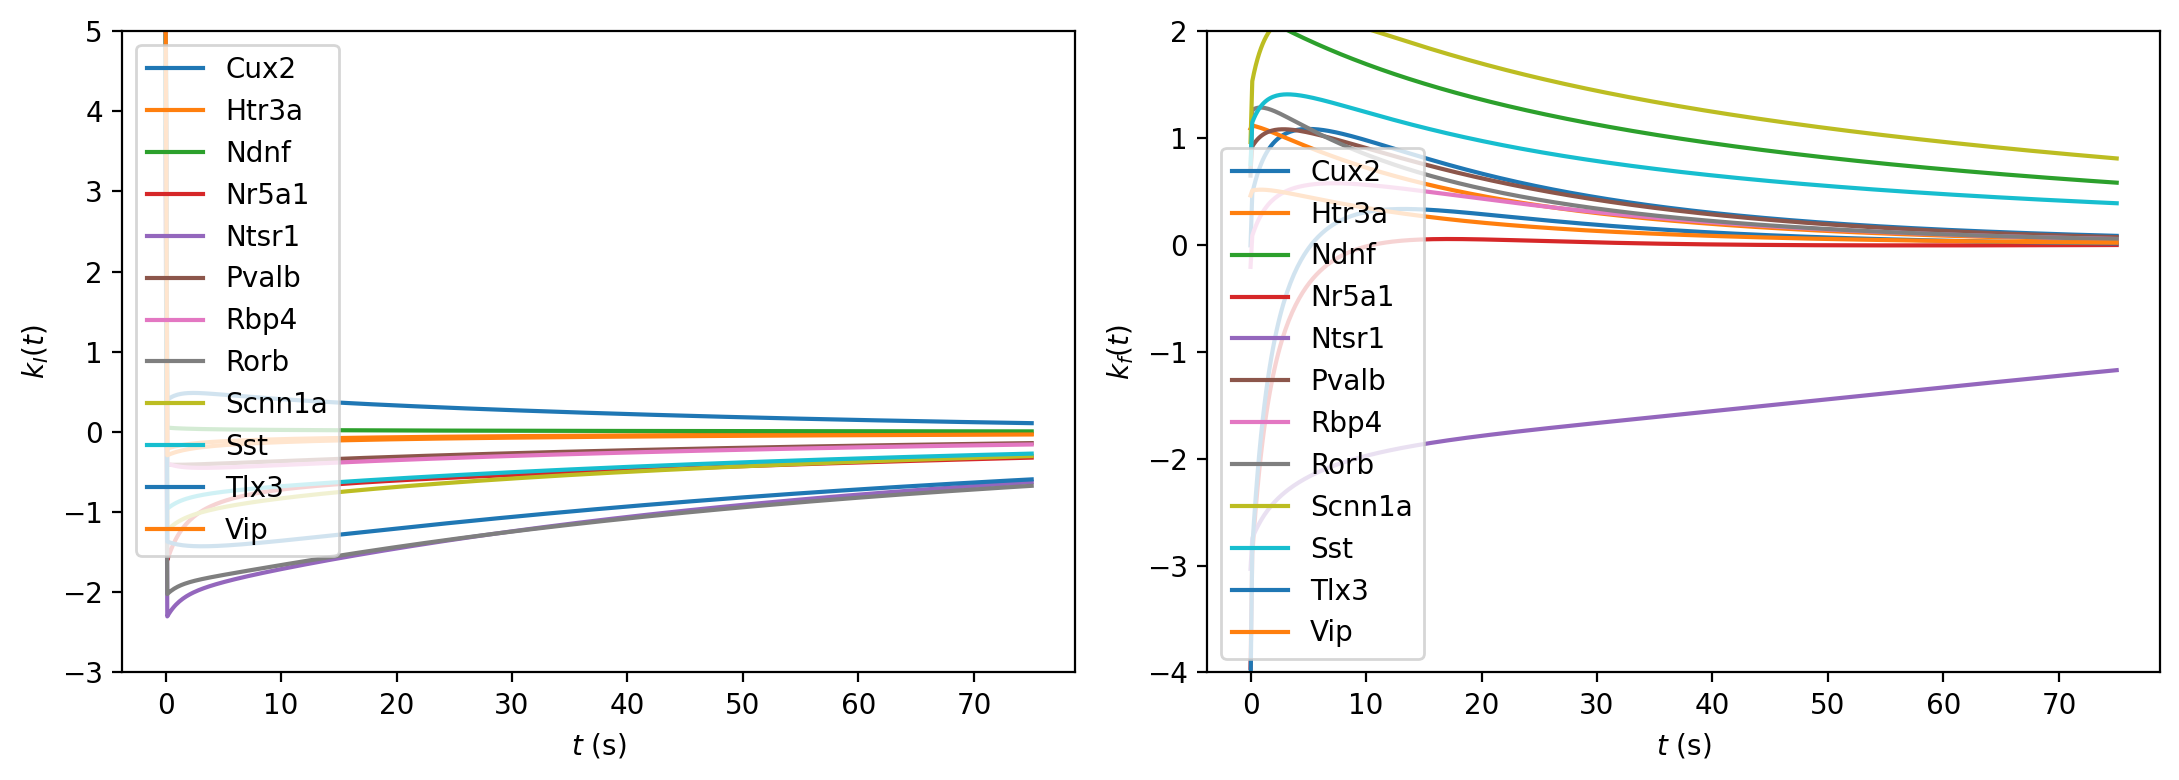

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(11, 4), dpi=200)
for i, t in enumerate(types):

    idx = int(np.random.rand(1) * np.sum(ys == t))
    a = xs[ys == t, :8][idx].reshape(1, -1)
    
    zs = torch.linspace(0, 75, 500)
    ki = [kernel(z, a) for z in zs]
    ax[0].plot(zs, ki, label=t)
    ax[0].legend()
    
    b = xs[ys == t, 8:16][idx].reshape(1, -1)
    
    zs = torch.linspace(0, 75, 500)
    kf = [kernel(z, b) for z in zs]
    ax[1].plot(zs, kf, label=t)
    ax[1].legend()

    ax[0].set_ylabel("$k_I(t)$")
    ax[0].set_xlabel("$t$ (s)")
    ax[1].set_ylabel("$k_f(t)$")
    ax[1].set_xlabel("$t$ (s)")
    ax[0].set_ylim([-3, 5])
    ax[1].set_ylim([-4, 2])

fig.tight_layout()

In [35]:
a.shape

(68, 8)

In [36]:
np.random.rand()

0.3352584308982688